# Analyzing the Correlation of Specific SNPs with BMI and Cardiovascular Diseases

## Imports

In [58]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import streamlit as st
import pickle
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance

## Data Preprocessing

In [39]:
# reading the data into a df + getting an initial look
df = pd.read_csv('patient_data.csv')

df.head()

,rs1047763,rs9282541,rs3827760,rs4988235,rs1801133,rs9374842,BMI,CardiovascularDisease
0,0,0,0,0,0,0,28.607859,0
1,0,0,1,1,0,0,26.651948,0
2,1,1,1,0,0,1,31.885502,0
3,0,0,1,0,0,0,29.353686,0
4,1,1,0,0,0,0,33.630251,0


In [40]:
#checking for null values
df.isna().sum()

rs1047763                0
rs9282541                0
rs3827760                0
rs4988235                0
rs1801133                0
rs9374842                0
BMI                      0
CardiovascularDisease    0
dtype: int64

### Train-Test-Split
As the df is imported and no null/NA values have been found, we now perform the train-test-split.

In [41]:
# Data preprocessing
X = df.drop('CardiovascularDisease', axis=1)
y = df['CardiovascularDisease']
X['BMI'] = StandardScaler().fit_transform(X['BMI'].values.reshape(-1, 1))

# Initialize a scaler
scaler = StandardScaler()

# Scale BMI column (assuming it's the last column before the target)
X_scaled = X.copy()
X_scaled['BMI'] = scaler.fit_transform(X[['BMI']])  # Fit and transform scaler on BMI

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)


## Logistic Regression Model

In [42]:
# Model initialization and training
model = LogisticRegression()
model.fit(X_train, y_train)

LogisticRegression()

### Predictions

In [43]:
# Predictions
predictions = model.predict(X_test)
print('Accuracy:', accuracy_score(y_test, predictions))
print('ROC AUC Score:', roc_auc_score(y_test, predictions))

Accuracy: 0.9833333333333333
ROC AUC Score: 0.9375


In [63]:
#first look at how the model is performing
print(classification_report(y_test, predictions, target_names=['Absent', 'Present']))

              precision    recall  f1-score   support

      Absent       0.98      1.00      0.99        52
     Present       1.00      0.88      0.93         8

    accuracy                           0.98        60
   macro avg       0.99      0.94      0.96        60
weighted avg       0.98      0.98      0.98        60



In the next step, I am computing the predicted labels with my model for the whole df, so I can identify cases in which the system made misclassifications.

In [56]:
# computing the predicted y for the whole df 
y_pred = model.predict(X)

#adding predicted y to the whole df
df_with_predictions = df.copy()
df_with_predictions['predictions'] = y_pred

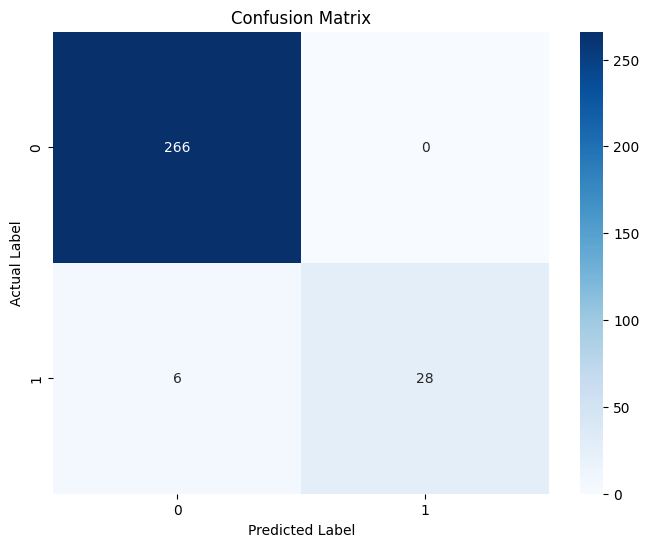

In [59]:
# Compute confusion matrix
cm = confusion_matrix(y, y_pred)

# Plotting the confusion matrix
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()

In [61]:
misclassifications = df_with_predictions[df_with_predictions['CardiovascularDisease'] != df_with_predictions['predictions']]

              precision    recall  f1-score   support

      Absent       0.98      1.00      0.99        52
     Present       1.00      0.88      0.93         8

    accuracy                           0.98        60
   macro avg       0.99      0.94      0.96        60
weighted avg       0.98      0.98      0.98        60



In [ ]:
df_with_predictions = 

## Streamlit Output

In [44]:
with open('model.pkl', 'wb') as file:
    pickle.dump(model, file)

with open('scaler.pkl', 'wb') as file:
    pickle.dump(scaler, file)

In [45]:
st.title('Cardiovascular Disease Prediction Tool')

# Model Coefficients Visualization (Optional)
st.write('Model Coefficients')
coefficients = pd.DataFrame(model.coef_[0], index=X.columns, columns=['Coefficient'])
st.bar_chart(coefficients)

# User input for prediction
st.write('Predict your risk')
bmi = st.slider('BMI', min_value=10.0, max_value=50.0, value=25.0, step=0.1)
snps = [st.selectbox(f'SNP{i+1}', [0, 1], index=0) for i in range(6)]

user_data = np.array([snps + [bmi]])
user_data[:, -1] = scaler.transform(user_data[:, -1].reshape(-1, 1))  # Scale BMI using the existing scaler

# Making prediction
user_prediction = model.predict_proba(user_data)[0, 1]
st.write(f'Predicted Risk of Cardiovascular Disease: {user_prediction:.2f}')



/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/opt/homebrew/lib/python3.11/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(


## Evaluate Algorithm Performance

### Permutation Feature Importance

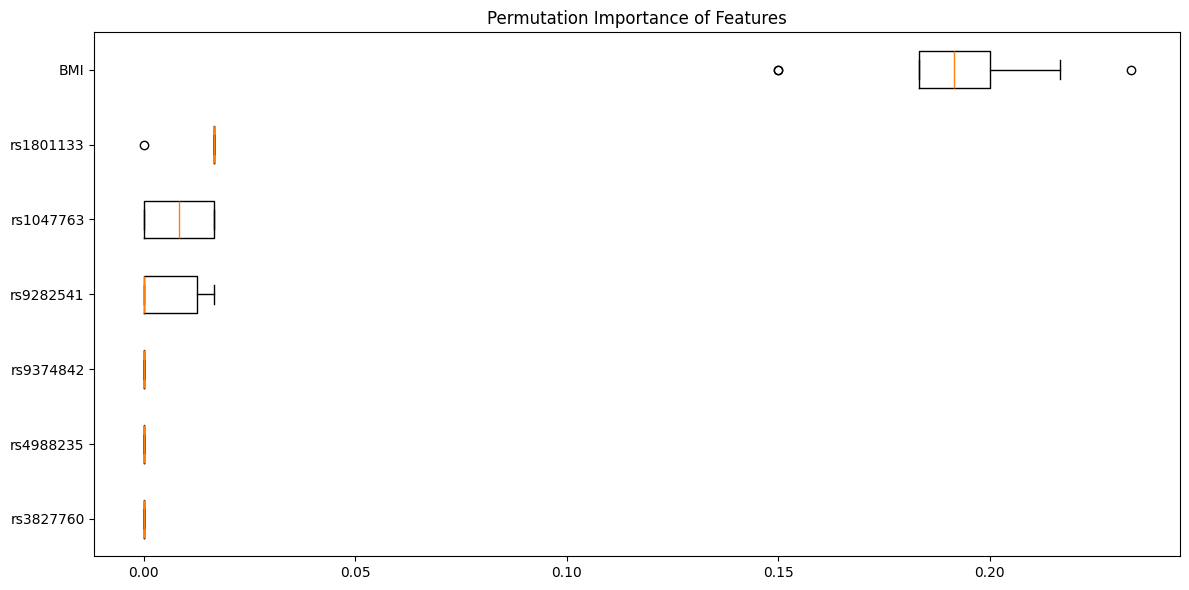

In [46]:
# Feature Permutation Importance
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = result.importances_mean.argsort()

# Plotting the feature importances
plt.figure(figsize=(12, 6))
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
plt.title("Permutation Importance of Features")
plt.tight_layout()
plt.show()

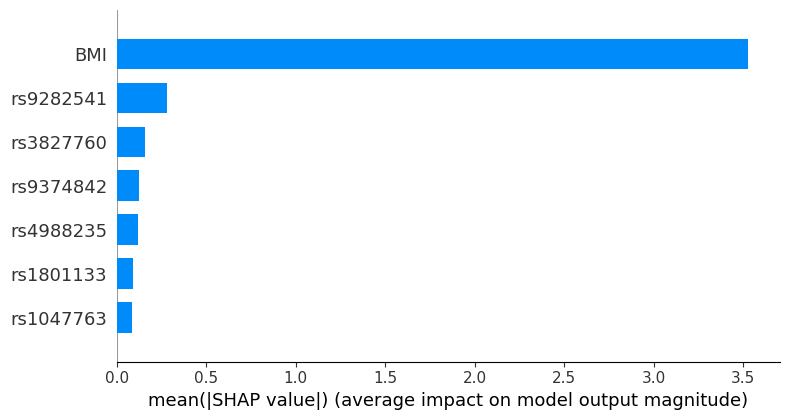

In [47]:
import shap
# SHAP Summary Plot
# Logistic Regression requires a linear explainer
explainer = shap.LinearExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)

# Summary plot for all features
shap.summary_plot(shap_values, X_test, plot_type="bar")
plt.show()

Accuracy: 0.98
Precision: 1.00
Recall: 0.88
F1 Score: 0.93
ROC AUC: 1.00


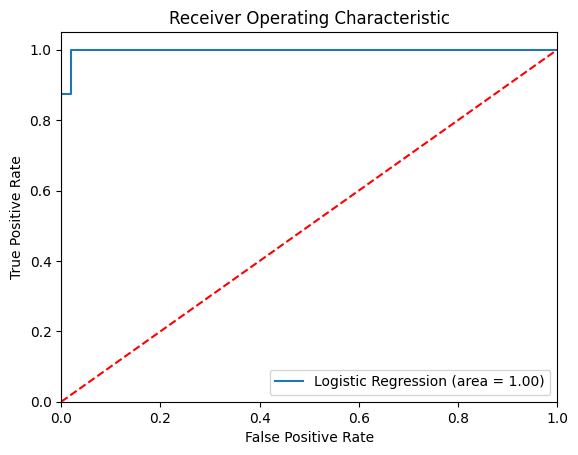

In [48]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Assuming predictions and y_test are already defined from your model testing phase
accuracy = accuracy_score(y_test, predictions)
precision = precision_score(y_test, predictions)
recall = recall_score(y_test, predictions)
f1 = f1_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, model.predict_proba(X_test)[:, 1])

print(f'Accuracy: {accuracy:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'F1 Score: {f1:.2f}')
print(f'ROC AUC: {roc_auc:.2f}')

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(X_test)[:, 1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


Random Forest Accuracy: 1.00
Random Forest Precision: 1.00
Random Forest Recall: 1.00
Random Forest F1 Score: 1.00
Random Forest ROC AUC: 1.00


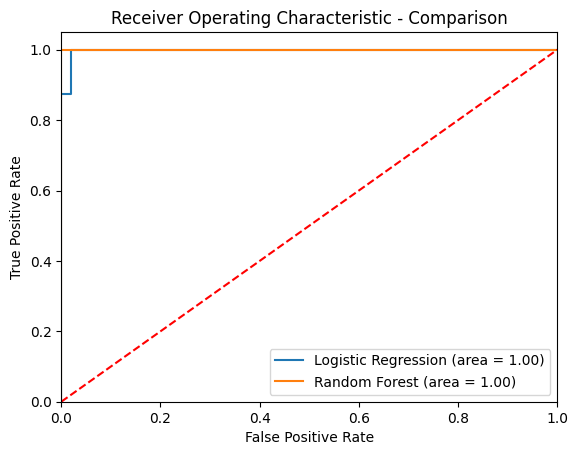

In [49]:
from sklearn.ensemble import RandomForestClassifier

# Initialize and train Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=0)
rf_model.fit(X_train, y_train)

# Predict using Random Forest
rf_predictions = rf_model.predict(X_test)
rf_roc_auc = roc_auc_score(y_test, rf_model.predict_proba(X_test)[:, 1])

# Metrics
rf_accuracy = accuracy_score(y_test, rf_predictions)
rf_precision = precision_score(y_test, rf_predictions)
rf_recall = recall_score(y_test, rf_predictions)
rf_f1 = f1_score(y_test, rf_predictions)

print(f'Random Forest Accuracy: {rf_accuracy:.2f}')
print(f'Random Forest Precision: {rf_precision:.2f}')
print(f'Random Forest Recall: {rf_recall:.2f}')
print(f'Random Forest F1 Score: {rf_f1:.2f}')
print(f'Random Forest ROC AUC: {rf_roc_auc:.2f}')

# Comparing ROC Curves
rf_fpr, rf_tpr, rf_thresholds = roc_curve(y_test, rf_model.predict_proba(X_test)[:, 1])
plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % roc_auc)
plt.plot(rf_fpr, rf_tpr, label='Random Forest (area = %0.2f)' % rf_roc_auc)
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic - Comparison')
plt.legend(loc="lower right")
plt.show()
